In [1]:
import re, pickle, gc, os, sys
from collections import defaultdict
from pathlib import Path

import pandas as pd
from datasketch import MinHash, MinHashLSHForest
from joblib import Parallel, delayed
from tqdm import tqdm

In [2]:
# ─────────────────────────────── parameters ────────────────────────────────
NUM_PERM = 128
CAND_N   = 300
TOP_K    = 10
N_JOBS   = max(os.cpu_count() - 1, 1)
TOK_RGX  = re.compile(r"\b\w+\b")    
# ───────────────────────────────────────────────────────────────────────────

def tokenize(text: str) -> set[str]:
    return set(TOK_RGX.findall(text.lower()))

def build_signature(tokens: set[str], num_perm=NUM_PERM) -> MinHash:
    m = MinHash(num_perm=num_perm)
    for t in tokens:
        m.update(t.encode())
    return m

In [3]:
df_resumes = pd.read_parquet("resumes.parquet")         # 4 k rows
df_jds_full     = pd.read_parquet("job_description.parquet")# 500 k rows

In [4]:
SAMPLE_SIZE = 50_000
RNG_SEED    = 42

df_jds = (
    df_jds_full
      .sample(n=SAMPLE_SIZE, random_state=RNG_SEED, replace=False)
      .reset_index(drop=True)
)

In [5]:
print('Resume Columns:', df_resumes.columns)
print('JD Columns:', df_jds.columns)

Resume Columns: Index(['resume_id', 'category', 'resume_text'], dtype='object')
JD Columns: Index(['jd_id', 'job_title', 'job_description'], dtype='object')


In [6]:
print("Tokenising job descriptions ...")
jd_tokens = Parallel(n_jobs=N_JOBS, batch_size=10_000)(
    delayed(tokenize)(txt) for txt in tqdm(df_jds["job_description"], total=len(df_jds))
)
df_jds["tokens"] = jd_tokens
jd_id_arr       = df_jds["jd_id"].values
tokens_dict     = dict(zip(jd_id_arr, jd_tokens))
del jd_tokens; gc.collect()

Tokenising job descriptions …


100%|█████████████████████████████████| 50000/50000 [00:00<00:00, 109343.87it/s]


26

In [7]:
print("Building MinHash signatures ...")
jd_sigs = Parallel(n_jobs=N_JOBS, batch_size=10_000)(
    delayed(build_signature)(tok) for tok in tqdm(df_jds["tokens"], total=len(df_jds))
)

Building MinHash signatures …


100%|█████████████████████████████████| 50000/50000 [00:00<00:00, 125508.37it/s]


In [8]:
forest = MinHashLSHForest(num_perm=NUM_PERM)
for jd_id, sig in zip(jd_id_arr, jd_sigs):
    forest.add(jd_id, sig)
forest.index()
del jd_sigs
print("LSH forest built")

LSH forest built ✓


In [9]:
def topk_for_resume(row):
    rid, rtxt = row.resume_id, row.resume_text
    r_tok     = tokenize(rtxt)
    r_sig     = build_signature(r_tok)
    cand_ids  = forest.query(r_sig, CAND_N)
    best      = []
    for cid in cand_ids:
        j_tok  = tokens_dict[cid]
        inter  = len(r_tok & j_tok)
        union  = len(r_tok) + len(j_tok) - inter
        score  = 0.0 if union == 0 else inter / union
        best.append((cid, score))
    best.sort(key=lambda x: x[1], reverse=True)
    return rid, [(cid, round(sc * 100, 2)) for cid, sc in best[:TOP_K]]

print("Scoring resumes …")
results = Parallel(n_jobs=N_JOBS, batch_size=256)(
    delayed(topk_for_resume)(row)
    for _, row in tqdm(df_resumes[["resume_id", "resume_text"]].iterrows(),
                       total=len(df_resumes))
)
topk_dict = dict(results)

Scoring resumes …


  0%|▏                                        | 15/4333 [00:03<19:51,  3.63it/s]/Users/chiragjain/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████████████████████████████████| 4333/4333 [00:24<00:00, 178.15it/s]


In [10]:
import json
Path("topk.json").write_text(json.dumps(topk_dict))

out_df = pd.DataFrame(
    {"resume_id": list(topk_dict.keys()),
     "top_matches": list(topk_dict.values())}
)
out_df.to_csv("topk.csv", index=False)

print("Done. Top‑K matches saved to topk.json & topk.csv")

Done. Top‑K matches saved to topk.json & topk.csv


Histogram blocks: 100%|█████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


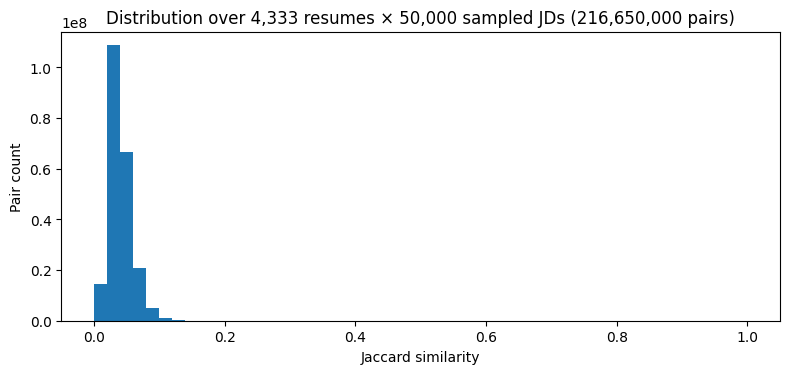

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np, matplotlib.pyplot as plt, tqdm, math
from scipy import sparse

cv = CountVectorizer(lowercase=True,
                     token_pattern=r'\b\w+\b',
                     binary=True)

corpus = (
    df_resumes["resume_text"].tolist() +
    df_jds["job_description"].tolist()
)

X  = cv.fit_transform(corpus)         
R  = len(df_resumes)
J  = len(df_jds)

X_res = X[:R]                         
X_jd  = X[R:]                         

len_A = X_res.sum(axis=1).A1
len_B = X_jd.sum(axis=1).A1 


BIN_EDGES = np.linspace(0, 1, 51, dtype=np.float32)  # 50 bins, width 0.02
hist      = np.zeros(len(BIN_EDGES) - 1, dtype=np.int64)

JD_BLOCK  = 5_000
n_blocks  = math.ceil(J / JD_BLOCK)

for b in tqdm.trange(n_blocks, desc="Histogram blocks"):
    j0, j1 = b * JD_BLOCK, min((b + 1) * JD_BLOCK, J)

    X_blk     = X_jd[j0:j1]                   
    len_B_blk = len_B[j0:j1]                  

    inter = (X_res @ X_blk.T).toarray()          
    union = len_A[:, None] + len_B_blk[None, :] - inter
    np.clip(union, 1, None, out=union)           
    jacc  = inter.astype(np.float32) / union

    hist += np.histogram(jacc, bins=BIN_EDGES)[0]

    del inter, union, jacc

plt.figure(figsize=(8, 4))
plt.bar(BIN_EDGES[:-1], hist,
        width=BIN_EDGES[1] - BIN_EDGES[0], align="edge")
plt.xlabel("Jaccard similarity")
plt.ylabel("Pair count")
plt.title(f"Distribution over {R:,} resumes × {J:,} sampled JDs "
          f"({hist.sum():,} pairs)")
plt.tight_layout()
plt.show()

In [12]:
# -------------------------------

In [13]:
import pandas as pd, re
from itertools import product    

In [14]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

STOP_WORDS = set(stopwords.words('english'))

def tokenize(text: str) -> set[str]:
    tokens = re.findall(r'\b\w+\b', text.lower())
    return {tok for tok in tokens if tok not in STOP_WORDS and not tok.isdigit()}

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chiragjain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
df_jds = pd.read_csv('./gold_samples/job_desc_sampled.csv')
df_resumes = pd.read_csv('./gold_samples/resumes_samples.csv')

In [16]:
df_resumes["tokens"] = df_resumes["resume_text"].map(tokenize)
df_jds["tokens"] = df_jds["job_description"].map(tokenize)

In [17]:
records = []
for (rid, r_tok), (jid, j_tok) in product(
        df_resumes[["resume_id", "tokens"]].itertuples(index=False),
        df_jds[    ["jd_id",     "tokens"]].itertuples(index=False)):
    inter = r_tok & j_tok
    union = r_tok | j_tok
    sim   = (len(inter) / len(union) if union else 0.0)
    records.append((rid, jid, sim))

In [18]:
jaccard_df = pd.DataFrame(records, columns=["resume_id", "jd_id", "jaccard"])

In [19]:
jaccard_df.describe()

,jaccard
count,2500.000000
mean,0.053607
std,0.021239
min,0.010554
25%,0.037037
50%,0.050955
75%,0.066908
max,0.141566


In [20]:
TOP_K = 10

topk = (
    jaccard_df
      .sort_values(['resume_id', 'jaccard'], ascending=[True, False])
      .groupby('resume_id', sort=False)
      .head(TOP_K)
)

out_df = (
    topk
      .assign(pct=lambda d: (d['jaccard'] * 100).round(2))
      .groupby('resume_id', sort=False)
      .apply(
          lambda g: list(zip(g['jd_id'], g['pct'])),
          include_groups=False          # <- new
      )
      .rename('top_matches')
      .reset_index()
)


In [21]:
pd.set_option('display.max_colwidth', None)
out_df.head(50)

,resume_id,top_matches
0,R1,"[(JD38, 10.88), (JD36, 10.0), (JD10, 9.94), (JD19, 9.91), (JD47, 9.44), (JD34, 9.35), (JD17, 9.31), (JD37, 9.29), (JD7, 8.8), (JD8, 8.78)]"
1,R10,"[(JD38, 11.25), (JD31, 10.61), (JD17, 9.69), (JD34, 9.49), (JD6, 9.47), (JD40, 9.31), (JD32, 9.13), (JD18, 8.74), (JD37, 8.2), (JD21, 7.91)]"
2,R11,"[(JD7, 8.19), (JD8, 7.49), (JD24, 7.03), (JD38, 7.01), (JD6, 7.0), (JD28, 6.5), (JD47, 6.23), (JD17, 6.16), (JD39, 5.88), (JD4, 5.86)]"
3,R12,"[(JD39, 8.18), (JD38, 7.09), (JD18, 6.68), (JD32, 6.36), (JD47, 6.33), (JD17, 5.83), (JD21, 5.83), (JD22, 5.67), (JD40, 5.65), (JD27, 5.47)]"
4,R13,"[(JD17, 8.95), (JD47, 8.05), (JD18, 7.46), (JD38, 7.36), (JD6, 6.78), (JD31, 6.21), (JD32, 6.18), (JD2, 6.15), (JD8, 6.06), (JD34, 6.04)]"
5,R14,"[(JD18, 7.62), (JD17, 6.71), (JD47, 6.13), (JD8, 5.3), (JD38, 5.25), (JD39, 5.21), (JD7, 5.17), (JD19, 5.14), (JD6, 5.07), (JD28, 5.06)]"
6,R15,"[(JD7, 7.11), (JD11, 6.52), (JD14, 6.52), (JD15, 6.47), (JD4, 5.88), (JD29, 5.84), (JD38, 5.82), (JD30, 5.8), (JD24, 5.63), (JD48, 5.48)]"
7,R16,"[(JD38, 9.89), (JD17, 9.6), (JD32, 8.29), (JD8, 7.67), (JD6, 6.96), (JD19, 6.86), (JD18, 6.7), (JD35, 6.52), (JD23, 6.34), (JD39, 6.21)]"
8,R17,"[(JD38, 12.4), (JD17, 11.01), (JD40, 9.74), (JD32, 9.71), (JD39, 9.61), (JD47, 9.27), (JD6, 9.25), (JD34, 9.23), (JD37, 8.3), (JD31, 8.27)]"
9,R18,"[(JD8, 6.76), (JD6, 6.53), (JD33, 6.21), (JD17, 6.18), (JD38, 6.08), (JD36, 5.75), (JD22, 5.68), (JD39, 5.67), (JD32, 5.42), (JD47, 5.39)]"


In [22]:
# l1 = ["Sysadmin", ".NET", "JavaScript", "PHP", "Data Science", "Python", "Java", "DevOps", "Node.js", "C++", "SQL", "Ruby", "Unity", "Android", "Data Engineer", "QA Automation", "Scala", "iOS", "QA", "Technical Writing", "Security", "Scrum Master", "Data Analyst", "Golang", "Flutter", "Rust", "Salesforce", "Block-chain", "SAP", "React", "Business Analyst", "Product Manager", "Product Owner", ]
# l2 = [ "Web Developer", "Network Engineer", "Software Tester", "UX/UI Designer", "QA Analyst", "Network Administrator", "Software Engineer", "Network Security Specialist", "UI Developer", "Data Analyst", "Technical Writer", "Systems Administrator", "Database Administrator", "Data Engineer", "Java Developer", "Front-End Engineer", "Front-End Developer", "Back-End Developer", "Systems Analyst", "Database Developer", "Software Developer", "IT Support Specialist", "Software Architect", "QA Engineer", "Data Scientist", "IT Manager", "IT Administrator", "Systems Engineer", "Network Technician", "UX Researcher", "Business Analyst", "Product Manager", ]
# l3 = ['Flutter Developer', 'Django Developer', 'Machine Learning', 'iOS Developer', 'Full Stack Developer', 'Java Developer', 'JavaScript Developer', 'DevOps Engineer', 'Software Engineer', 'Database Administrator', 'Wordpress Developer', 'PHP Developer', 'Backend Developer', 'Network Administrator', 'Node js developer']

# len(l1 + l2 + l3)

In [30]:
import re, numpy as np
import pandas as pd

K          = 10
GOLD_PATH  = "gold_res.txt"

gold = {}
with open(GOLD_PATH) as f:
    for raw in f:
        raw = raw.strip()
        if not raw:
            continue
        rid, rest = raw.split(":", 1)
        rid = rid.strip()
        jd_ids = re.findall(r'JD\d+', rest)
        gold[rid] = jd_ids


pred = {
    rid: [jd for jd, _ in row.top_matches][:K]
    for rid, row in out_df.set_index("resume_id").iterrows()
}


def dcg(rel):
    return sum(r / np.log2(i + 2) for i, r in enumerate(rel))


prec, rec, acc, rr, ndcg = [], [], [], [], []

per_res = {}

for rid, gold_ids in gold.items():
    if rid not in pred:
        continue

    p   = pred[rid]
    hits = [int(j in gold_ids) for j in p]

    p_at_k = sum(hits) / len(p)
    r_at_k = sum(hits) / len(gold_ids) if gold_ids else 0
    has_hit = any(hits)
    recip_rank = next((1/(i+1) for i,h in enumerate(hits) if h), 0)

    ideal = min(len(gold_ids), K)
    ndcg_score = dcg(hits) / dcg([1]*ideal) if ideal > 0 else 0

    # accumulate overall
    prec.append(p_at_k)
    rec.append(r_at_k)
    acc.append(1 if has_hit else 0)
    rr.append(recip_rank)
    ndcg.append(ndcg_score)

    # store per-resume
    per_res[rid] = {
        f"Precision@{K}": round(p_at_k, 1),
        f"Recall@{K}":  round(r_at_k, 1),
        f"MRR@{K}":  round(recip_rank, 1),
        f"NDCG@{K}":  round(ndcg_score, 1)
    }


print(f"Evaluated on {len(prec)} resumes that appear in both gold & preds\n")
print(f"Precision@{K}:   {np.mean(prec):.4f}")
print(f"Recall@{K}:      {np.mean(rec):.4f}")
print(f"Top‑{K} accuracy: {np.mean(acc):.4f}")
print(f"MRR@{K}:          {np.mean(rr):.4f}")
print(f"NDCG@{K}:         {np.mean(ndcg):.4f}\n")


per_df = pd.DataFrame(per_res).T  # rows=resume_id, cols=[Prec@K, Rec@K]
per_df.index.name = "Resume"
print("Per‑resume Precision@K and Recall@K:\n")
per_df.T

Evaluated on 50 resumes that appear in both gold & preds

Precision@10:   0.2880
Recall@10:      0.2880
Top‑10 accuracy: 1.0000
MRR@10:          0.6519
NDCG@10:         0.3213

Per‑resume Precision@K and Recall@K:



Resume,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,...,R41,R42,R43,R44,R45,R46,R47,R48,R49,R50
Precision@10,0.3,0.4,0.5,0.3,0.6,0.2,0.3,0.2,0.2,0.3,...,0.4,0.2,0.2,0.1,0.3,0.2,0.5,0.5,0.5,0.2
Recall@10,0.3,0.4,0.5,0.3,0.6,0.2,0.3,0.2,0.2,0.3,...,0.4,0.2,0.2,0.1,0.3,0.2,0.5,0.5,0.5,0.2
MRR@10,1.0,1.0,1.0,1.0,1.0,0.1,0.3,0.3,0.2,1.0,...,0.2,0.2,1.0,0.1,1.0,1.0,1.0,1.0,1.0,1.0
NDCG@10,0.4,0.5,0.6,0.4,0.7,0.1,0.2,0.2,0.2,0.4,...,0.3,0.1,0.3,0.1,0.4,0.3,0.6,0.6,0.5,0.3


In [24]:
def jaccard_breakdown(resume_id: str, jd_id: str,
                      resumes=df_resumes, jds=df_jds) -> None:

    try:
        r_tok = resumes.loc[resumes.resume_id == resume_id, "tokens"].iat[0]
    except IndexError:
        raise ValueError(f"resume_id {resume_id!r} not found")

    try:
        j_tok = jds.loc[jds.jd_id == jd_id, "tokens"].iat[0]
    except IndexError:
        raise ValueError(f"jd_id {jd_id!r} not found")

    inter = r_tok & j_tok
    union = r_tok | j_tok

    print(f"Resume {resume_id}  ×  JD {jd_id}")
    print("-" * 60)
    print(f"Common tokens ({len(inter)}):")
    print(", ".join(sorted(inter)) or "∅")
    print()
    print(f"|R| = Resume tokens ............ {len(r_tok)}")
    print(f"|J| = JD tokens ................ {len(j_tok)}")
    print(f"|R∩J| = intersection ........... {len(inter)}")
    print(f"|R∪J| = union .................. {len(union)}")
    jacc = len(inter) / len(union) if union else 0.0
    print(f"Jaccard similarity ............. {jacc:.4f}")

In [25]:
# Gold -> R1 : [JD2, JD4, JD1, JD5, JD3, JD38, JD37, JD40, JD39, JD36]

In [26]:
out_df.head(1)

,resume_id,top_matches
0,R1,"[(JD38, 10.88), (JD36, 10.0), (JD10, 9.94), (JD19, 9.91), (JD47, 9.44), (JD34, 9.35), (JD17, 9.31), (JD37, 9.29), (JD7, 8.8), (JD8, 8.78)]"


In [27]:
df_resumes.columns

Index(['resume_id', 'category', 'resume_text', 'tokens'], dtype='object')

In [28]:
jaccard_breakdown("R27", "JD27")

Resume R27  ×  JD JD27
------------------------------------------------------------
Common tokens (67):
activities, agile, bank, base, business, changing, cloud, communication, corporate, data, db, deployment, design, developed, development, different, engineer, engineering, enterprise, environment, etl, experience, expertise, git, health, hours, implementation, including, insurance, knowledge, loading, managing, medical, models, one, oracle, people, populating, power, practices, processing, product, professional, projects, provided, requirements, responsibilities, responsible, science, sessions, skills, solutions, sql, stakeholders, strong, supply, support, team, teams, technical, tools, training, use, using, work, working, years

|R| = Resume tokens ............ 565
|J| = JD tokens ................ 522
|R∩J| = intersection ........... 67
|R∪J| = union .................. 1020
Jaccard similarity ............. 0.0657


In [111]:
jaccard_breakdown("R1", "JD2")

Resume R1  ×  JD JD2
------------------------------------------------------------
Common tokens (21):
applications, backend, client, code, companies, developer, development, education, executives, experience, features, insurance, interface, java, new, senior, software, team, teams, work, years

|R| = Resume tokens ............ 136
|J| = JD tokens ................ 177
|R∩J| = intersection ........... 21
|R∪J| = union .................. 292
Jaccard similarity ............. 0.0719


In [112]:
# Gold -> R2 : [JD2, JD4, JD1, JD5, JD38, JD37, JD39, JD40, JD3, JD36]

In [113]:
display(out_df.iloc[[11]])

,resume_id,top_matches
11,R2,"[(JD38, 14.16), (JD40, 11.1), (JD17, 10.22), (JD6, 9.94), (JD31, 8.81), (JD39, 8.79), (JD37, 8.66), (JD21, 8.56), (JD7, 8.47), (JD32, 8.46)]"


In [114]:
jaccard_breakdown("R2", "JD38")

Resume R2  ×  JD JD38
------------------------------------------------------------
Common tokens (94):
agile, angular, api, application, applications, architecture, assets, automated, bachelor, based, best, build, building, business, c, cases, classes, client, cloud, code, coding, communication, computer, core, cross, css, data, database, db, design, development, driven, end, entity, environment, experience, expertise, framework, frameworks, front, full, git, grid, hands, html, identifying, implementing, including, integration, java, javascript, large, like, logic, methodologies, microservices, orm, patterns, platforms, practices, problem, project, related, requirements, restful, science, security, server, service, services, side, skills, software, solving, sql, stack, strong, systems, tdd, team, teams, technologies, technology, test, testing, tools, unit, use, using, utilizing, web, well, work, years

|R| = Resume tokens ............ 466
|J| = JD tokens ................ 292
|R∩J| = in

In [115]:
jaccard_breakdown("R2", "JD2")

Resume R2  ×  JD JD2
------------------------------------------------------------
Common tokens (48):
ability, apache, applications, best, building, class, client, code, components, container, developer, developing, development, docker, education, environment, existing, experience, fast, features, implementing, including, integrated, interface, internal, java, knowledge, new, open, planning, practices, process, rest, reviewing, side, software, spring, support, tdd, team, teams, technologies, test, tools, training, well, work, years

|R| = Resume tokens ............ 466
|J| = JD tokens ................ 177
|R∩J| = intersection ........... 48
|R∪J| = union .................. 595
Jaccard similarity ............. 0.0807


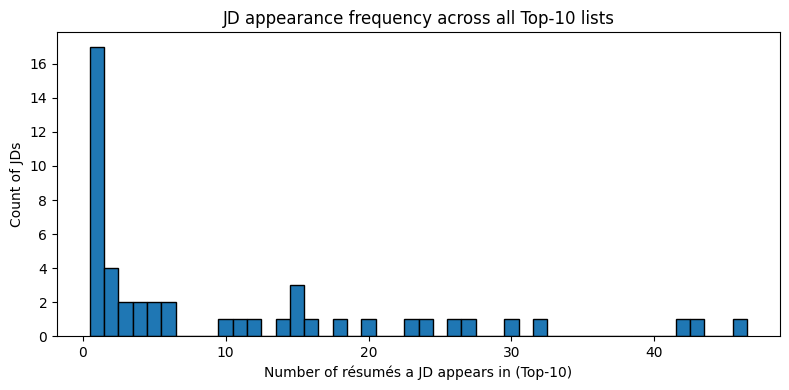


Top‑20 Job Descriptions most frequently recommended:


,Frequency
JD ID,
JD38,46
JD6,43
JD17,42
JD34,32
JD32,30
JD8,27
JD40,26
JD39,24
JD18,23


<Figure size 1000x400 with 0 Axes>

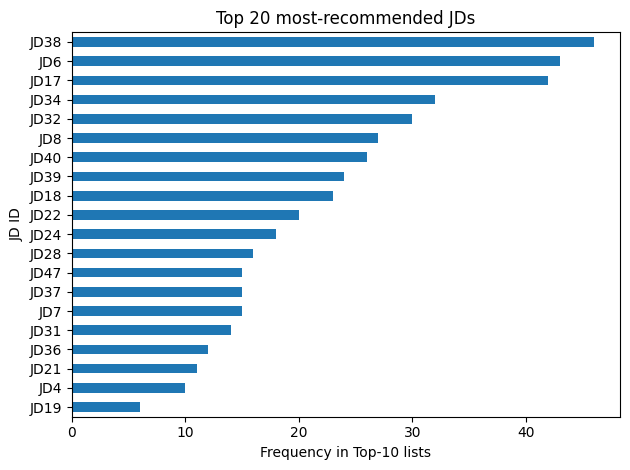

In [100]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

jd_counts = collections.Counter()

for lst in out_df["top_matches"]:
    for jd_id, _ in lst:            # ignore the score
        jd_counts[str(jd_id)] += 1  # make sure key is str for consistency

freqs = list(jd_counts.values())
plt.figure(figsize=(8, 4))
plt.hist(
    freqs,
    bins=np.arange(1, max(freqs) + 2),   # 1 .. max_freq inclusive
    align="left",
    edgecolor="black"
)
plt.xlabel("Number of résumés a JD appears in (Top‑10)")
plt.ylabel("Count of JDs")
plt.title("JD appearance frequency across all Top‑10 lists")
plt.tight_layout()
plt.show()

TOP_N = 20
top_df = (
    pd.DataFrame(jd_counts.most_common(TOP_N), columns=["JD ID", "Frequency"])
    .set_index("JD ID")
)

print("\nTop‑{} Job Descriptions most frequently recommended:".format(TOP_N))
display(top_df)

plt.figure(figsize=(10, 4))
top_df.sort_values("Frequency").plot.barh(legend=False)
plt.xlabel("Frequency in Top‑10 lists")
plt.title(f"Top {TOP_N} most‑recommended JDs")
plt.tight_layout()
plt.show()


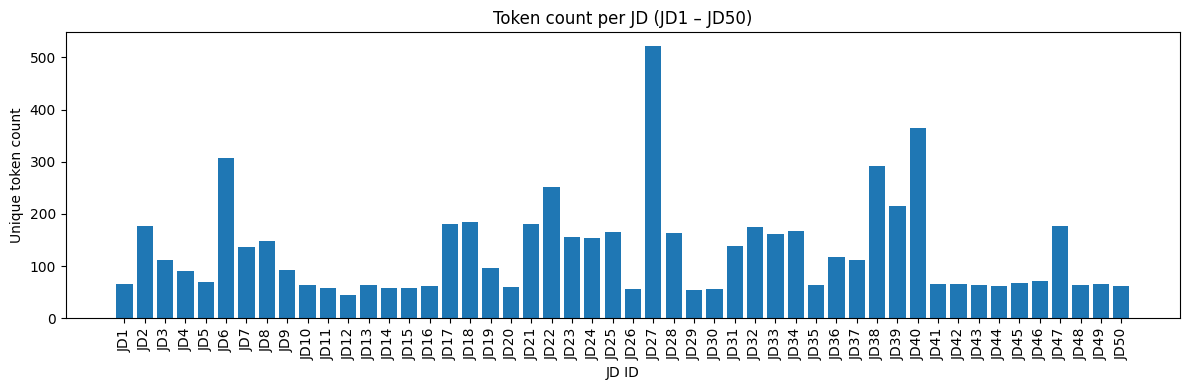

In [101]:
import re
import pandas as pd
import matplotlib.pyplot as plt

if "tokens" not in df_jds.columns:
    token_rgx = re.compile(r"\b\w+\b")
    df_jds["tokens"] = df_jds["job_description"].str.lower().apply(
        lambda txt: set(token_rgx.findall(txt))
    )

df_jds["tok_len"] = df_jds["tokens"].str.len()

def jd_num(jd):
    m = re.match(r"JD(\d+)", str(jd))
    return int(m.group(1)) if m else None

subset = (
    df_jds
      .assign(num=df_jds["jd_id"].map(jd_num))
      .dropna(subset=["num"])
      .sort_values("num")
      .query("num <= 50")
)

plt.figure(figsize=(12, 4))
plt.bar(subset["jd_id"], subset["tok_len"])
plt.xlabel("JD ID")
plt.ylabel("Unique token count")
plt.title("Token count per JD (JD1 – JD50)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
